# DDPG Solution to the BiPedalWalker problem

Thus far we have seen the use of DQN and DDQN networks to solve RL problems. Such algorithms are limited in that they can only chose a single scalar action per timestep, i.e. a CHOICE of what action to take. Such problems are limited in reality as we often need to output a range of values for each action per timestep (i.e. a vector action). 

An example would be, in controlling a robot arm, we do not need a binary choice of which servo to *turn on* but a list of locations for each servo.

Lets look at the actions spaces of two problems.

In [1]:
import gym
envList=['LunarLander-v2', 'BipedalWalker-v3']
for envName in envList:
    env = gym.make(envName)
    observation=env.reset()
    print('\n'+envName)
    print('action space is shaped like ',env.action_space)
    print('state space size is',env.observation_space.shape)


LunarLander-v2
action space is shaped like  Discrete(4)
state space size is (8,)

BipedalWalker-v3
action space is shaped like  Box(4,)
state space size is (24,)


/home/cdinneen/miniconda3/envs/aigym/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## DDPG Methods

To start with we are going to create two networks, an actor and a critic. The actor is going to determine the action values in the action vector and the critic is going to evaluate the value of these actions.

(Note the code for this problem is heavily borrowed from  here: https://github.com/ghliu/pytorch-ddpg/blob/master/

In [2]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gym import wrappers, envs
import time

In [1]:

from misc import plot_reward


import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import pickle


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('BipedalWalker-v3')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Turn interactive mode on.
plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using', device, 'for simulation.')

Using cuda for simulation.


/home/cdinneen/miniconda3/envs/aigym/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [19]:
env.action_space

Box(4,)

In [2]:
class Actor_Network(nn.Module):
    '''Actor network
    Inputs are ints of size'''
    def __init__(self, state, action,hidden1=150, hidden2=120):
        super(Actor_Network, self).__init__()
        self.FCL1 = nn.Linear(state,hidden1)
        self.FCL2 = nn.Linear(hidden1,hidden2)
        self.FCL3 = nn.Linear(hidden2,action)

    def forward(self, x):
        '''input states, return action'''
        x = F.relu(self.FCL1(x))
        x = F.relu(self.FCL2(x))
        x = torch.tanh(self.FCL3(x))
        return x
    
class Critic_Network(nn.Module):
    '''A Deep Q network for predicting actions given states'''
    def __init__(self, state, action, hidden1=150, hidden2=120):
        super(Critic_Network, self).__init__()
        self.FCL1 = nn.Linear(state,hidden1)
        self.FCL2 = nn.Linear(hidden1+action, hidden2)
        self.FCL3 = nn.Linear(hidden2,1)

    def forward(self, state, action):
        '''input stateaction, output value'''
        x = F.relu(self.FCL1(state))
        x = self.FCL2(torch.cat([x,action],dim=1))
        x = F.relu(x)
        x = self.FCL3(x)
        return x

In [3]:
'''A mapping of state-action pairs to next-state reward results'''
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'isDone'))


class ReplayMemory(object):
    '''a cyclic buffer of bounded size that holds recently observed transitions.'''

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            # if we are at less than capacity, allocate fresh space for the transition
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        '''Randomly return a batch of batch_size from the memory'''
        return random.sample(self.memory, batch_size)
    
    def get_item(self, memloc):
        '''Show Transition stored at memloc'''
        return self.memory[memloc]
    
    def clear(self):
        self.memory = []
        self.position = 0

    def __len__(self):
        
        return len(self.memory)
    
    def save(self):
        file = open('replay_buffer.obj', 'wb')
        pickle.dump(self.memory, file)
        file.close()

    def load(self):
        try:
            filehandler = open('replay_buffer.obj', 'rb')
            self.memory = pickle.load(filehandler)
            self.position = len(self.buffer)
        except:
            print('there was no file to load')


In [4]:
def select_action(state, training=True):
    '''torch.tensor -> torch.tensor
    
    Chooses an epsilon-greedy action given an input state.'''
    
#    eps_threshold = min(EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY),1.0)

    action = policy_actor_net(state).detach()
    action = action.squeeze(0).cpu().numpy()
    action += training * max(epsilon, epsilon_min) * rnoise.noise()
    action = np.clip(action, -1.0, 1.0)
    return action

def soft_update(target, source, tau=0.001):
    """
    update target by target = tau * source + (1 - tau) * target
    :param target: Target network
    :param source: source network
    :param tau: 0 < tau << 1
    :return:
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )    
    
def optimize_model():
    '''
    None -> float,float
    
    Update the actor and critic networks via SGD.
    returns actor loss and critic loss.
    '''
    if len(memory) < BATCH_SIZE:
        #print("Warning: We do not have enough history in memory to optimize our network")
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch 
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)
    isDone_batch = torch.cat(batch.isDone)
    
    
    next_action_batch = target_actor_net(next_state_batch).detach()

    target_q = target_critic_net(next_state_batch, next_action_batch).detach()
    
    y_expected = reward_batch + isDone_batch*gamma * target_q
    y_predicted = policy_critic_net.forward(state_batch, action_batch)

    # critic gradient
    critic_loss = nn.MSELoss()
    loss_critic = critic_loss(y_predicted, y_expected)
    critic_optimizer.zero_grad()
    loss_critic.backward()
    critic_optimizer.step()

    # actor gradient
    pred_a = policy_actor_net.forward(state_batch)
    loss_actor = (-policy_critic_net.forward(state_batch, pred_a)).mean()
    actor_optimizer.zero_grad()
    loss_actor.backward()
    actor_optimizer.step()
    
    soft_update(target_actor_net, policy_actor_net, tau=0.001)
    soft_update(target_critic_net, policy_critic_net, tau=0.001)
    #target_actor_net.parameters().data.copy_(target_actor_net.parameters().data*(1.0 -tau) + tau*policy_actor_net.parameters())
    #target_critic_net.parameters().data.copy_(target_critic_net.parameters().data*(1.0 -tau) + tau*policy_critic_net.parameters())
    
    return loss_actor.item(), loss_critic.item()
    
    

In [5]:
import numpy as np 

class OUNoise:
    """docstring for OUNoise"""
    def __init__(self, action_dimension, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [6]:
'''
ToDo:

implement Add epsilon noise values.
'''

# Get number of actions from gym action space
n_actions = 4
# Get length of state space from gym observation space
n_states = 24

# Create two actor networks
policy_actor_net = Actor_Network(n_states, n_actions).to(device)
target_actor_net = Actor_Network(n_states, n_actions).to(device)
# Duplicate the weights and biases of the policy net into the target net.
target_actor_net.load_state_dict(policy_actor_net.state_dict())

# Create two critic networks
policy_critic_net = Critic_Network(n_states, n_actions).to(device)
target_critic_net = Critic_Network(n_states, n_actions).to(device)
# Duplicate the weights and biases of the policy net into the target net.
target_critic_net.load_state_dict(policy_critic_net.state_dict())

target_actor_net.eval()
target_critic_net.eval()

rnoise=OUNoise(n_actions)

actor_optimizer = optim.Adam(policy_actor_net.parameters(),lr=0.001)
critic_optimizer = optim.Adam(policy_critic_net.parameters(),lr=0.001)
# Initialise the memory object.
memory = ReplayMemory(2000)
memory.clear()

steps_done = 0
episode_durations = []
reward_values = []
action_values=[]
frame_values=[]
env.close()

In [15]:
BATCH_SIZE = 512
# Discount Factor
GAMMA = 0.99
epsilon=0.6
epsilon_min=0.05

gamma=0.99


# How often do we update our policy network parameters (in steps)
TARGET_UPDATE = 10

Complete


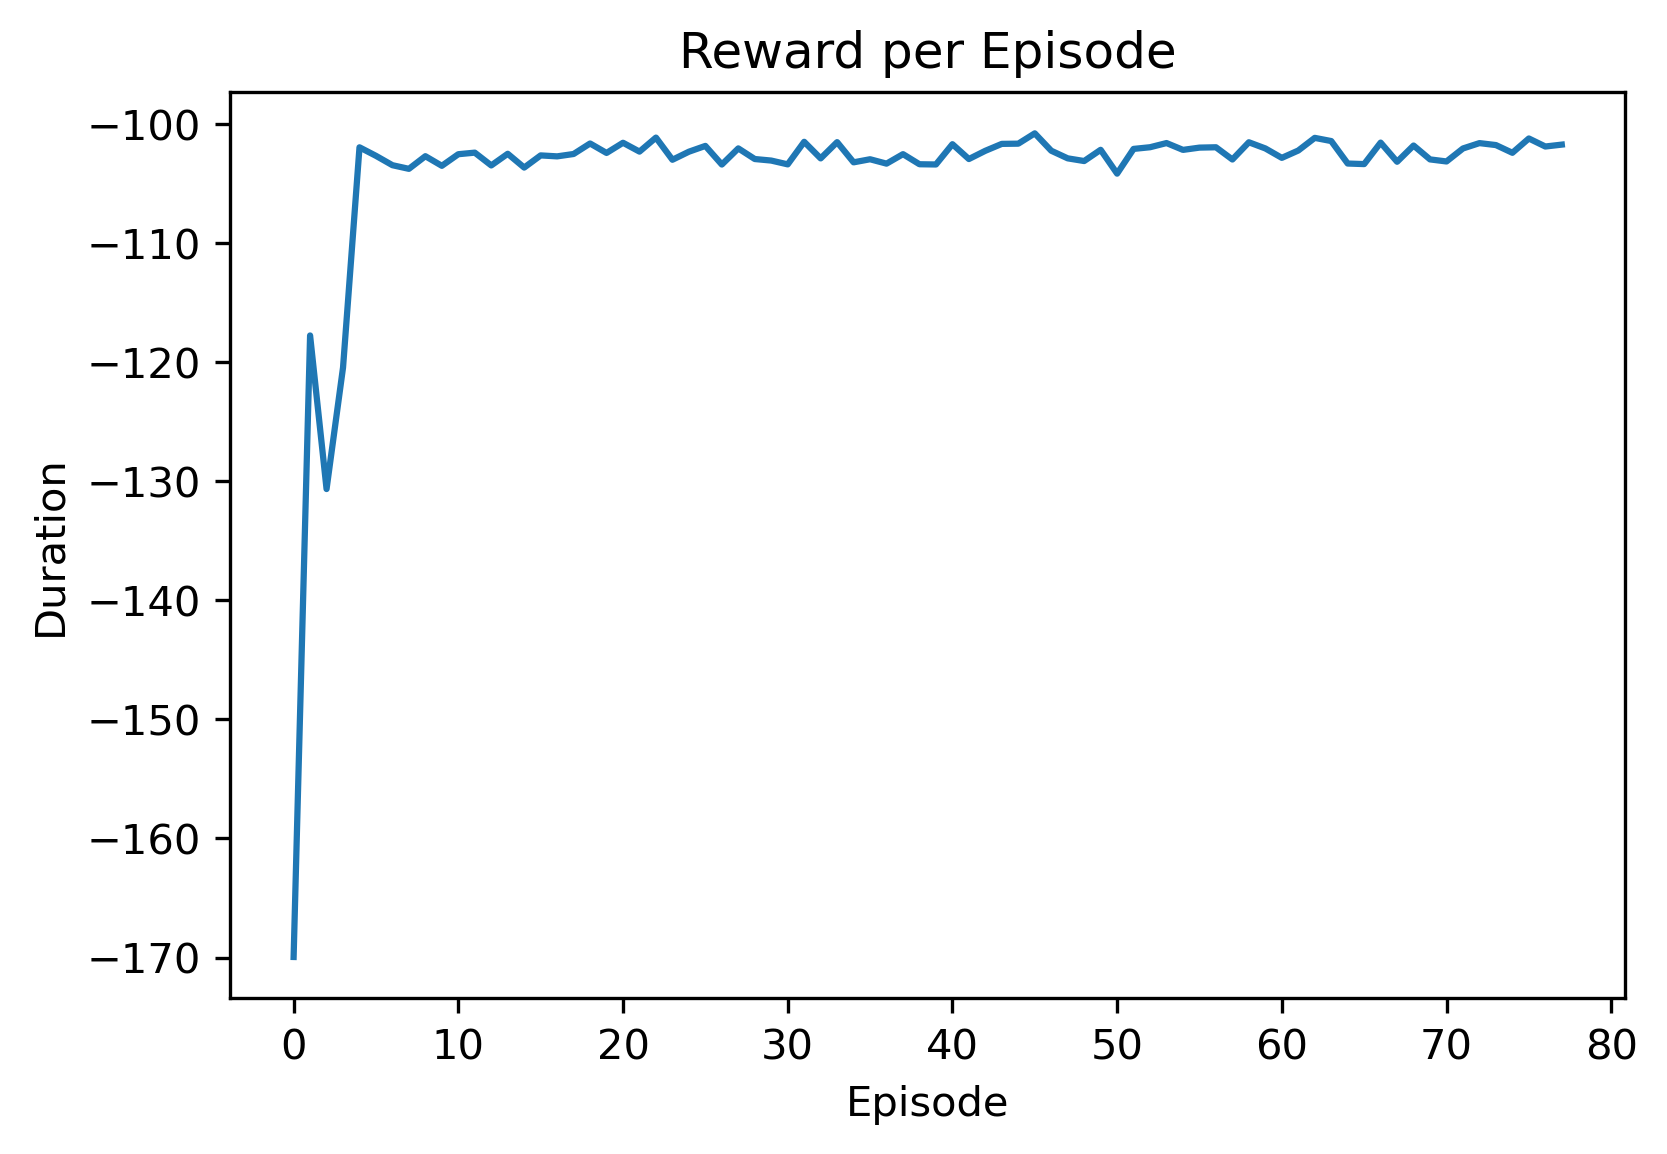

In [18]:
num_episodes = 50
for i_episode in range(num_episodes):
    state = torch.from_numpy(np.cast['float32'](env.reset())).unsqueeze(0).to(device)
    TotalReward=0
    for t in count():
        action = select_action(state)
        #print(action)
        next_state, reward, done, _ = env.step(action)
        
        #env.render()
        TotalReward+= reward
        action = torch.from_numpy(np.cast['float32'](action)).unsqueeze(0).to(device)
        next_state = torch.from_numpy(np.cast['float32'](next_state)).unsqueeze(0).to(device)
        reward = torch.tensor([reward], device=device,dtype=torch.float32).unsqueeze(0)

        if not done:
            isDone = 0
        else:
            isDone = 1 
        isDone = torch.tensor([isDone], device=device,dtype=torch.float32).unsqueeze(0)
        memory.push(state, action, next_state, reward, isDone)
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        
        if done:
            episode_durations.append(t + 1)
            reward_values.append(TotalReward)
            plot_reward(reward_values)
            break
        
   # if i_episode % TARGET_UPDATE == 0:
        # Update the target network, copying all weights and biases in DQN
        #target_net.load_state_dict(policy_net.state_dict())

print('Complete')
#env.render()
env.close()
#plt.ioff()
#plt.show()
plot_reward(reward_values)

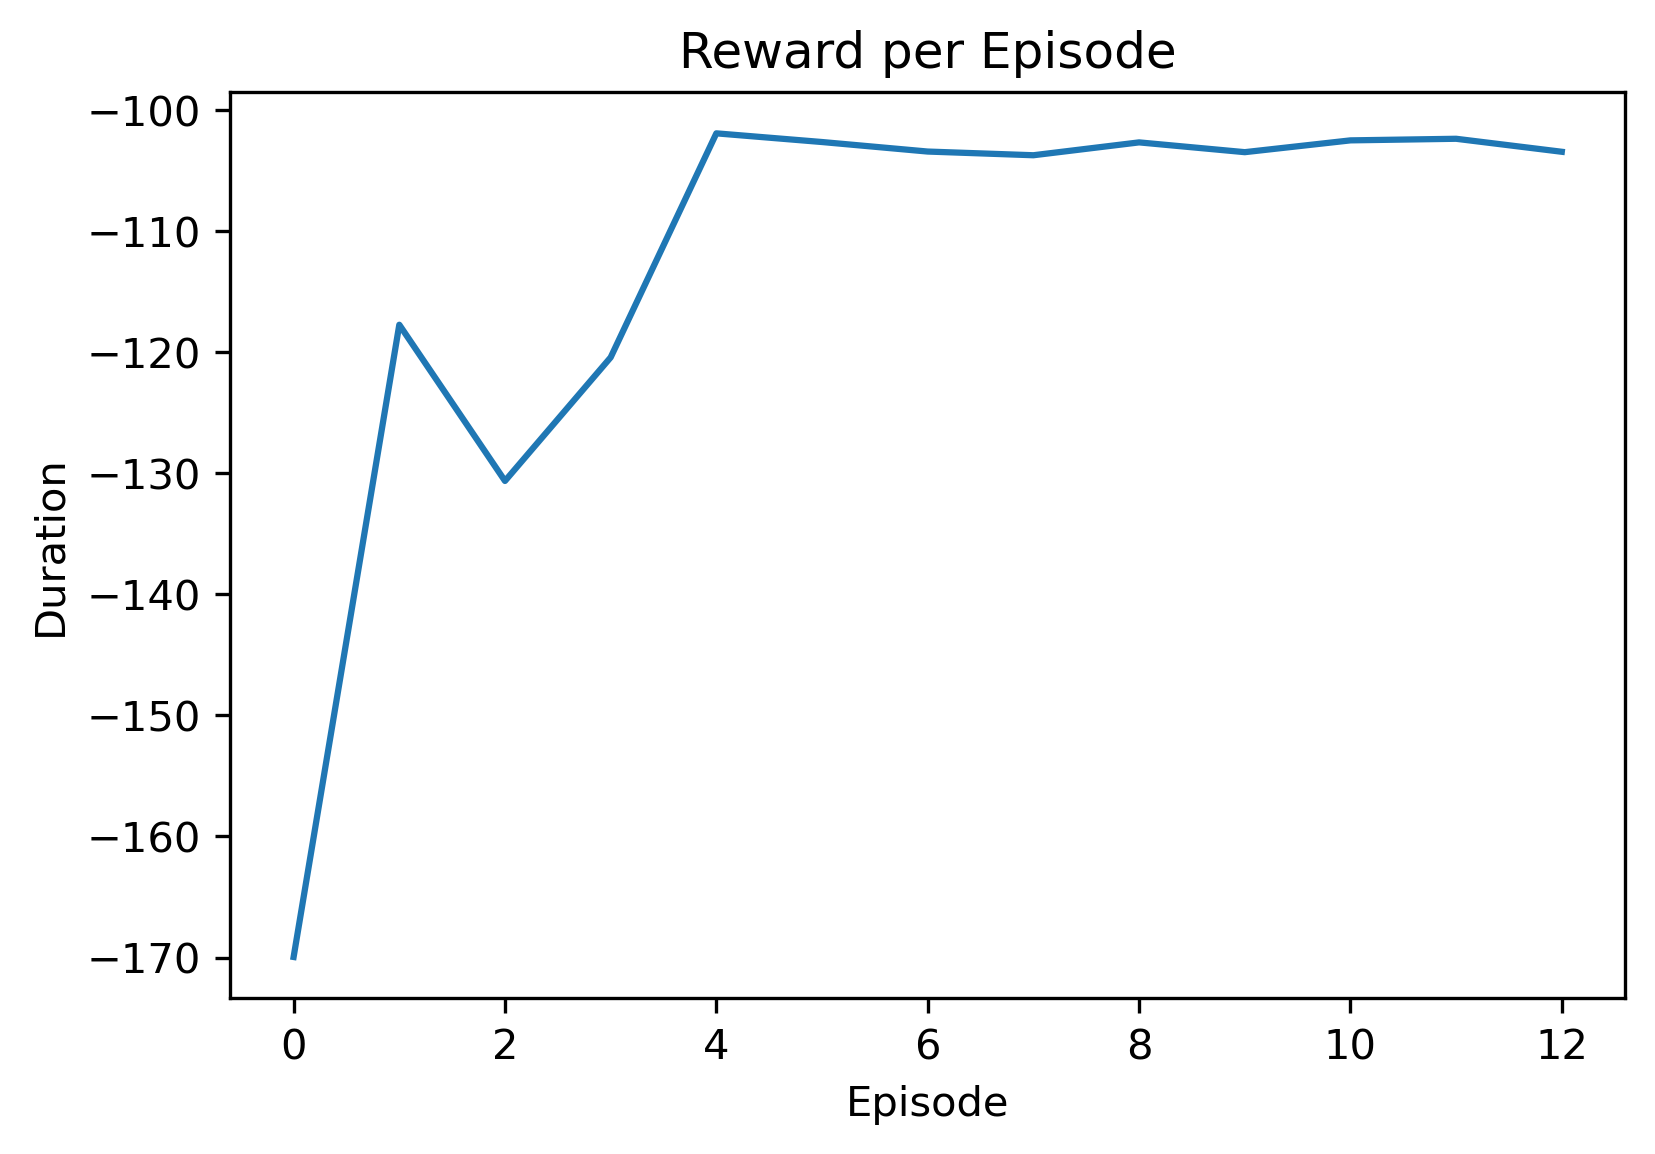

In [13]:

def plot_reward(reward_input, pngout=False, pngpath='ouput.png'):
    '''
    List -> matplotlib.plt

    pngout (bool):  Save reward as png file.
    pngpath (str):  Location to save png file.


    Show the reward per episode on the yaxis.
    After 100 episodes also plot a moving average.
    '''
    plt.figure(2,dpi=300) 
    durations_t = torch.tensor(reward_input, dtype=torch.float)
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(reward_values)
    if pngout:
        plt.savefig(pngpath)
    else:
        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            display.clear_output(wait=True)
            

plot_reward(reward_values)



In [17]:
env.close()

In [33]:
torch.zeros((24,4), device=device)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], device='cuda:0')